In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import itertools
import neal
import dimod
from dwave.system import DWaveCliqueSampler, DWaveSampler, LeapHybridSampler
import matplotlib.colors as colors
import dwave.inspector
import os
import json
import argparse
import re
import matplotlib.patches as mpatches
import matplotlib

In [2]:
# Define MI calculations
def prob(dataset):
    """Joint probability distribution P(X) for the given data."""

    # bin by the number of different values per feature
    num_rows, num_columns = dataset.shape
    bins = [len(np.unique(dataset[:, ci])) for ci in range(num_columns)]

    prob, _ = np.histogramdd(dataset, bins)
    return prob / np.sum(prob)


def shannon_entropy(p):
    """Shannon entropy H(X) is the negative sum of P(X)log(P(X)) for probability
    distribution P(X).
    """
    p = p.flatten()
    return -sum(pi*np.log2(pi) for pi in p if pi)


def conditional_shannon_entropy(p, *conditional_indices):
    """Conditional Shannon entropy H(X|Y) = H(X,Y) - H(Y)."""

    # Sanity check on validity of conditional_indices.  In particular,
    # try to trap issues in which dimensions have been removed from
    # probability table through marginalization, but
    # conditional_indices were not updated accordingly.
    assert(all(ci < p.ndim for ci in conditional_indices))

    axis = tuple(i for i in np.arange(len(p.shape))
                 if i not in conditional_indices)

    return shannon_entropy(p) - shannon_entropy(np.sum(p, axis=axis))


def mutual_information(prob, j):
    """Mutual information between variables X and variable Y.
    Calculated as I(X; Y) = H(X) - H(X|Y)."""

    return (shannon_entropy(np.sum(prob, axis=j))
            - conditional_shannon_entropy(prob, j))


def conditional_mutual_information(p, j, *conditional_indices):
    """Mutual information between variables X and variable Y conditional on variable Z.
    Calculated as I(X;Y|Z) = H(X|Z) - H(X|Y,Z)"""

    # Compute an updated version of the conditional indices for use
    # when the probability table is marginalized over dimension j.
    # This marginalization removes one dimension, so any conditional
    # indices pointing to dimensions after this one must be adjusted
    # accordingly.
    marginal_conditional_indices = [i-1 if i > j else i for i in conditional_indices]

    return (conditional_shannon_entropy(np.sum(p, axis=j), *marginal_conditional_indices)
            - conditional_shannon_entropy(p, j, *conditional_indices))

In [93]:
def maximum_energy_delta(bqm):
    """Compute conservative bound on maximum change in energy when flipping a single variable"""
    return max(abs(bqm.get_linear(i))
               + sum(abs(bqm.get_quadratic(i,j))
                     for j in bqm.iter_neighbors(i))
               for i in bqm.iter_variables())

def chain_generators(a, b):
    """Chain two generators up. Conceptualy, it works as generators concanenation"""
    yield from a
    yield from b
    

def mutual_information_bqm(dataset, features, mandatory_features, target):
    """Build a BQM that maximizes MI between survival and a subset of features"""
    non_mandatory_features = list(set(features) - set(mandatory_features))
    fixed_variables = (((feature, -10)) for feature in mandatory_features)
    variables = ((feature, -mutual_information(prob(dataset[[target, feature]].values), 1))
                 for feature in non_mandatory_features)
    interactions = ((f0, f1, -conditional_mutual_information(prob(dataset[[target, f0, f1]].values), 1, 2))
                    for f0, f1 in itertools.permutations(features, 2))
    

    return dimod.BinaryQuadraticModel(chain_generators(fixed_variables, variables), interactions, 0, dimod.BINARY)


def add_combination_penalty(bqm, k, penalty):
    """Create a new BQM with an additional penalty biased towards k-combinations"""
    kbqm = dimod.generators.combinations(bqm.variables, k, strength=penalty)
    kbqm.update(bqm)
    return kbqm

def add_restricted_penalty(bqm, flex_set, k, penalty):
    """Create a new BQM with an additional penalty biased towards k-combinations"""
    kbqm = dimod.generators.combinations(flex_set, k, strength=penalty)
    kbqm.update(bqm)
    return kbqm

def mutual_information_feature_selection(dataset, features, target, max_features = 10, mandatory_features = [], restricted_features = ([],0), num_reads=5000,):
    """Run the MIFS algorithm on a QPU solver"""
    
    # Set up a QPU sampler that embeds to a fully-connected graph of all the variables
    #sampler = DWaveCliqueSampler(solver=dict(qpu=True)) # to be used after testing 
    sampler = LeapHybridSampler()
    #sampler = neal.SimulatedAnnealingSampler()
    #sampler = neal.Neal()
    # For each number of features, k, penalize selection of fewer or more features

    #bqm = mutual_information_bqm(dataset, features, mandatory_features, target)
    bqm = mutual_information_bqm(dataset, features, [], target)
    
    # This ensures that the soltion will satisfy the constraints.
    penalty = maximum_energy_delta(bqm)
    res_arr = []
    
    # creat list of free searched features. 
    free_features = list(set(features) - set(mandatory_features) - set(restricted_features[0]))
    #all_features = list(set(features) + set(mandatory_features) + set(restricted_features[0]))
    all_features = features
    
    #add penatly to choose all mendatory features (alternativelly fill [] argument in mutual_information_bqm)
    if(len(mandatory_features) > 0):
        bqm = add_restricted_penalty(bqm, mandatory_features, len(mandatory_features), penalty) 
    
    #add penatly to restricted variables (e.g. choose k from set of variables X)
    if(restricted_features[0]!=[]):
        bqm = add_restricted_penalty(bqm,restricted_features[0], restricted_features[1], penalty)
    
    num_selected_features = min(len(free_features), max_features)
    selected_features = np.zeros((num_selected_features, len(all_features)))
        
    for k in range(2, num_selected_features+1, 1):
        kbqm = add_restricted_penalty(bqm, free_features, k, penalty)
        sample = sampler.sample(kbqm,
                                label='Example - MI Feature Selection')#,
                                #num_reads=num_reads)
        #dwave.inspector.show(sample)
        #break
        res_arr.append(sample)
        #print(sum(list(res_arr[-1].first.values.values())))
        for fi, f in enumerate(features):
            selected_features[k-2, fi] = sample.first.sample[f]
    
    #selected_features = selected_features[:-1]        
    #save_samples(selected_features, len(features), )
    return selected_features, res_arr

def mutual_information_feature_selection_model(dataset, features, target, k, mandatory_features = [], restricted_features = ([],0)):
    """Return binary quadratic model used in the MIFS"""
    
    
    # Set up a QPU sampler that embeds to a fully-connected graph of all the variables
    #sampler = DWaveCliqueSampler(solver=dict(qpu=True)) # to be used after testing 
    sampler = LeapHybridSampler()
    #sampler = neal.SimulatedAnnealingSampler()
    #sampler = neal.Neal()
    # For each number of features, k, penalize selection of fewer or more features

    #bqm = mutual_information_bqm(dataset, features, mandatory_features, target)
    bqm = mutual_information_bqm(dataset, features, [], target)
    
    # This ensures that the soltion will satisfy the constraints.
    penalty = maximum_energy_delta(bqm)
    res_arr = []
    
    # creat list of free searched features. 
    free_features = list(set(features) - set(mandatory_features) - set(restricted_features[0]))
    #all_features = list(set(features) + set(mandatory_features) + set(restricted_features[0]))
    all_features = features
    
    #add penatly to choose all mendatory features (alternativelly fill [] argument in mutual_information_bqm)
    if(len(mandatory_features) > 0):
        bqm = add_restricted_penalty(bqm, mandatory_features, len(mandatory_features), penalty) 
    
    #add penatly to restricted variables (e.g. choose k from set of variables X)
    if(restricted_features[0]!=[]):
        bqm = add_restricted_penalty(bqm,restricted_features[0], restricted_features[1], penalty)
    
    return add_restricted_penalty(bqm, free_features, k, penalty)

def save_samples(samples, solver, parent_dir = "Results/", embeding = "embhyb"):
    """Save sampleSet from simulation in given directory. (saving file format .json)"""
    
    path = os.path.join(parent_dir, solver)
    os.makedirs(path, exist_ok = True)
    for sample in samples:    
        file_name = str(sum(list(sample.samples())[0].values())) +".json"
        file_path = os.path.join(path, file_name)
        with open(file_path, 'w', encoding='utf-8') as jsonf:
            json.dump(sample.to_serializable(), jsonf)     
        
def retrive_sample_set(directory):
    """Retrive sample set from directory. """
    
    sampleSet = []
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        if os.path.isfile(f) and filename.endswith('.json'):
            with open(f) as file:
                sampleSet.append(dimod.SampleSet.from_serializable(json.load(file)))
                
    return sampleSet          

In [92]:
# load data from csv file
df_pre = pd.read_csv("data/formatted_medical7_raw_clean3.csv",header=0, sep="\,")

# drop first two columns as they are redundant 
df_pre.drop('Unnamed: 0', axis = 1, inplace = True)
df_pre.drop('Unnamed: 0.1', axis = 1, inplace = True)
df_pre.drop('Nazwy przyp.', axis = 1, inplace = True)

# define list of features excluded form further computing
exclude_features = ['eGFR +6 (MDRD)', 'eGFR +12 (MDRD)', 'eGFR +3 (MDRD)']
# remove excluded features form the data frame
try: 
    for pop_feature in exclude_features:
        df_pre.drop(pop_feature, axis = 1, inplace = True)
except:
    print("One of the excluded features does not belong to the data frame")
    
# define target variable 
target ="Graft loss 1 year"

# define a tuple of restricted list by # choosen (list, #)
restricted_features = (['eGFR -12 (MDRD-4)', 'eGFR -3 (MDRD-4)', 'Mean baseline eGFR (MDRD-4)'],1)
try:
    if len(restricted_features[0])<=restricted_features[1] or restricted_features[1]<=0:
        raise ValueError
except:
    print("Restricted features wrong dimensionality.")

# define the list of mandatory features
mandatory_features = ['Urinary sepsis',
'KTx- Sepsis/UTI/visit [months]',
'AB and Dr mismatch',
'Induction',
'CIT [min]',
'peak-PRA [%]',
'Donor',
'Charlston Comorbidity Index' ,
'FSGS',
'Albumins [g/dl]',
'Tripple maintenance therapy before admission',
'Steroid bolus',
'Reduction 3--> 2',
'Reduction to steroid only',
'AKI - KDIGO 2012',
'Acute RRT initiation',
'Transfusion [YES/NO]',
'GCS',
'Next UTI - 6 months',
'Another urosepsis 1 year']

# define the list of all features 
all_features = list(df_pre.columns)

# check if all mandatory features are in the data frame
try:
    if set(mandatory_features) - set(all_features) != set():
        raise ValueError
except: 
    print("Value error! Features of mandatory set do not belong to the table of data")

# check if all restircted features are in the data frame
try:
    if set(restricted_features[0]) - set(all_features) != set():
        raise ValueError
except: 
    print("Value error! Features of restricted set do not belong to the table of data")


<ipython-input-92-cf121fc38b18>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_pre = pd.read_csv("data/formatted_medical7_raw_clean3.csv",header=0, sep="\,")


In [84]:
# Rank the MI between survival and every other variable
scores = {feature: mutual_information(prob(df_pre[[target, feature]].values), 0)
          for feature in set(df_pre.columns) - {target}}

# Select (keep) features with the top MI ranking found above.
#keep = len(df.columns)
keep = 60
# num_reads = 1000 - value to be used in the case of pure QPU or QPU simulator

# remove mandatory and restricted features from search space
for feature_to_drop in mandatory_features + restricted_features[0]:
    scores.pop(feature_to_drop)
    
# sort search space by the influence strength
sorted_scores = sorted(scores.items(), key=lambda pair: pair[1], reverse=True)

# number of search features 
num_free_features = keep - 1 - len(mandatory_features) - len(restricted_features[0])

# list of search features
search_feature = [target] + mandatory_features + restricted_features[0]  + [column[0] for column in sorted_scores[0:num_free_features]]
# data frame of search features 
df_sort = df_pre[search_feature]

features = sorted(list(set(df_sort.columns) - {target}))

# run MIQUBO optimization on hybrid solver
selected_features, samples = mutual_information_feature_selection(
    df_sort, 
    features, 
    target, 
    10, 
    mandatory_features,
    restricted_features)

#seva sample sets in a given directory
save_samples(samples, "hybrid2")

In [25]:
#set(restricted_features[0])
mandatory_features

['Urinary sepsis',
 'KTx- Sepsis/UTI/visit [months]',
 'AB and Dr mismatch',
 'Induction',
 'CIT [min]',
 'peak-PRA [%]',
 'Donor',
 'Charlston Comorbidity Index',
 'FSGS',
 'Albumins [g/dl]',
 'Tripple maintenance therapy before admission',
 'Steroid bolus',
 'Reduction 3--> 2',
 'Reduction to steroid only',
 'AKI - KDIGO 2012',
 'Acute RRT initiation',
 'Transfusion [True/False]',
 'GCS',
 'Next UTI - 6 months',
 'Another urosepsis 1 year']

In [13]:
samples = retrive_sample_set("Results/mrf_auto5_hybrid_hybrid")

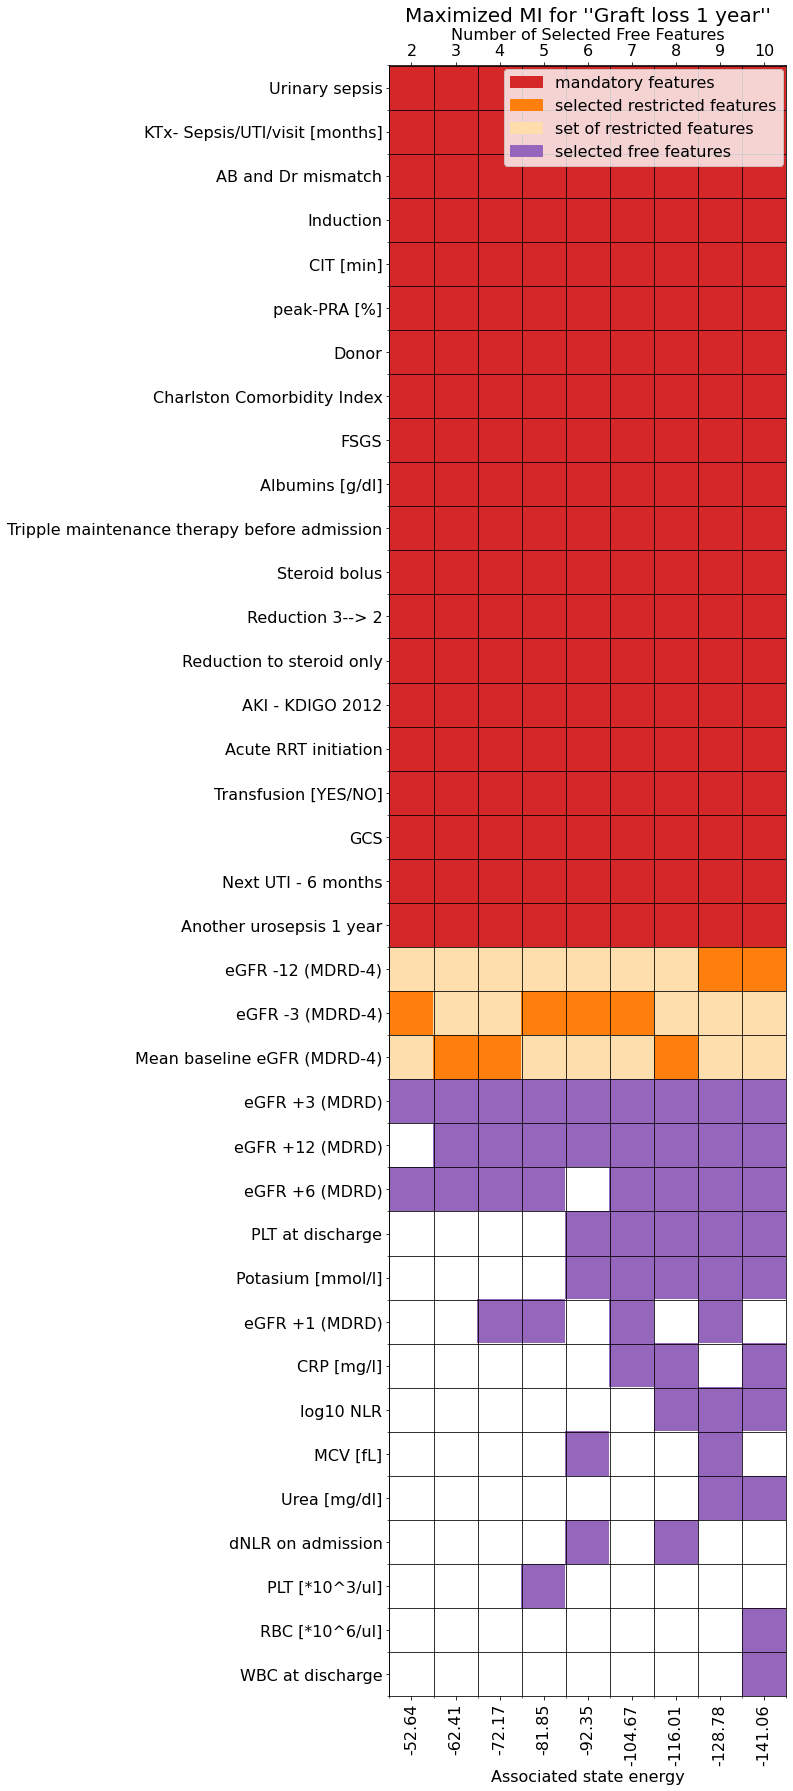

In [85]:
stacked_mask, selected_features = plot_features_grid(samples, mandatory_features, restricted_features, plot_name = "Plots/Final2/MITable2.png" )

In [86]:
selected_features2, samples2 = mutual_information_feature_selection(
    df_sort, 
    selected_features, 
    target, 
    num_reads, 
    10, 
    mandatory_features,
    restricted_features)

save_samples(samples, "hybrid3")

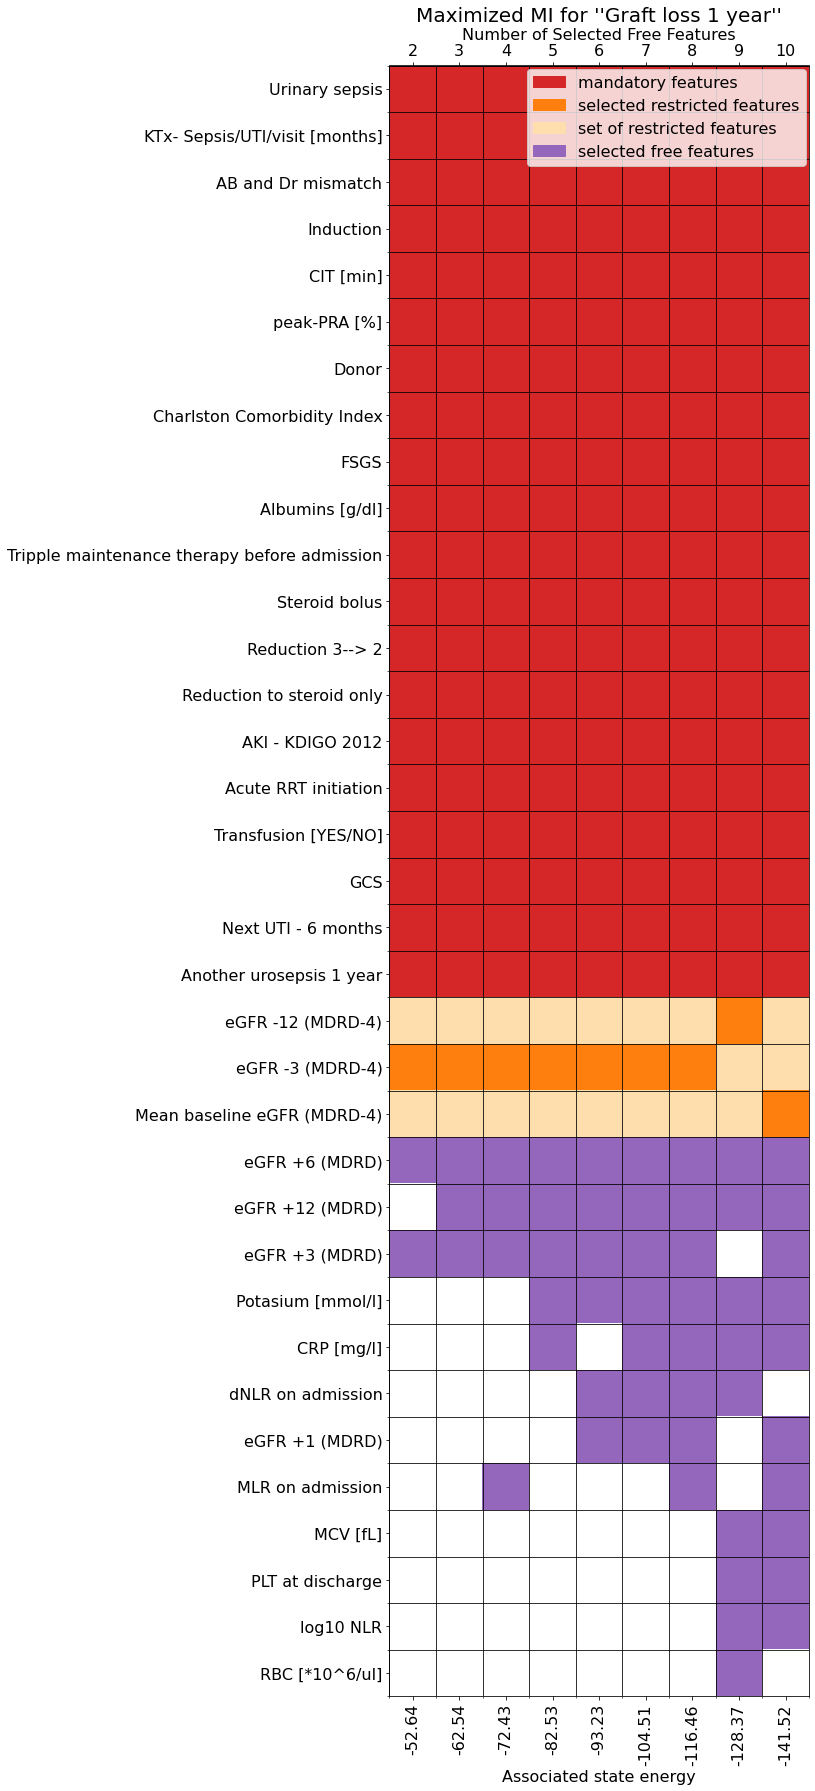

In [87]:
stacked_mask2, selected_features2 = plot_features_grid(samples2, mandatory_features, restricted_features, plot_name = "Plots/Final2/MITable3.png")

In [88]:
selected_features2

['Urinary sepsis',
 'KTx- Sepsis/UTI/visit [months]',
 'AB and Dr mismatch',
 'Induction',
 'CIT [min]',
 'peak-PRA [%]',
 'Donor',
 'Charlston Comorbidity Index',
 'FSGS',
 'Albumins [g/dl]',
 'Tripple maintenance therapy before admission',
 'Steroid bolus',
 'Reduction 3--> 2',
 'Reduction to steroid only',
 'AKI - KDIGO 2012',
 'Acute RRT initiation',
 'Transfusion [YES/NO]',
 'GCS',
 'Next UTI - 6 months',
 'Another urosepsis 1 year',
 'eGFR -12 (MDRD-4)',
 'eGFR -3 (MDRD-4)',
 'Mean baseline eGFR (MDRD-4)',
 'eGFR +6 (MDRD)',
 'eGFR +12 (MDRD)',
 'eGFR +3 (MDRD)',
 'Potasium [mmol/l]',
 'CRP [mg/l]',
 'dNLR on admission',
 'eGFR +1 (MDRD)',
 'MLR on admission',
 'MCV [fL]',
 'PLT at discharge',
 'log10 NLR',
 'RBC [*10^6/ul]',
 'Age',
 'BMI',
 'CRP at discharge',
 'Composite endpoint (DEATH / GRAFT LOSS/ ACUTE REJECTION',
 'Composite endpoint (DEATH / GRAFT LOSS/ ACUTE REJECTION/ eGFR decline>20% to baseline',
 'Composite endpoint - observation time [days]',
 'Creatinine',
 'Creat

In [33]:
restricted_energy_tuning(samples, df_sort, features, target, 2, mandatory_features, restricted_features )

[(-14.667533935198662, -14.212873060994752, -14.671936766362705, 23),
 (-19.300673699297477, -18.793215261630394, -19.305079828711314, 24),
 (-24.57606244154522, -23.95764162748128, -24.580479066244152, 25),
 (-30.39618887043798, -29.688343399217047, -30.400591500389055, 26),
 (-36.59799756605571, -35.810794866232754, -36.60242190220197, 27),
 (-43.93024493708617, -43.125109535467345, -43.9346861873164, 28),
 (-51.83722114466582, -50.86790063358603, -51.841606303303706, 29),
 (-60.011915538158064, -59.00635963798413, -60.016319823927915, 30),
 (-68.45288234729742, -67.40292288416458, -68.4574107590779, 31)]

In [7]:
#var = "Next"
#res = list(filter(re.compile(".*"+var+"*").match, features))
#print(res)
#features.index(res[1])
list(filter(re.compile(".*"+"eGFR"+"*").match, all_features))

['eGFR -12 (MDRD-4)',
 'eGFR -3 (MDRD-4)',
 'Mean baseline eGFR (MDRD-4)',
 'eGFR +1 (MDRD)',
 'eGFR +3 (MDRD)',
 'eGFR +6 (MDRD)',
 'eGFR +12 (MDRD)',
 'Composite endpoint (DEATH / GRAFT LOSS/ ACUTE REJECTION/ eGFR decline>20% to baseline']

In [ ]:
df_pre = pd.read_csv("data/formatted_medical6_clean_raw.csv",header=0, sep="\,")
df_post = pd.read_csv("data/formatted_medical5_clean.csv",header=0, sep="\,")
df_pre.drop(['Unnamed: 0'], axis = 1, inplace = True)
df_post.drop(['Unnamed: 0'], axis = 1, inplace = True)
df_post.rename(columns={'AFalsether urosepsis 1 year - observation':'Another urosepsis 1 year - observation'}, inplace = True)

'AFalsether urosepsis 1 year - observation',
"""
df_post.drop(['Column1'], axis = 1, inplace = True)
df_pre.drop(['Unnamed: 0'], axis = 1, inplace = True)
df_pre.to_csv("data/formatted_medical5_clean_raw.csv")
df_post.to_csv("data/formatted_medical5_clean.csv")
"""
print(len(df_pre.columns))
print(len(df_post.columns))

In [ ]:
keep = len(df.columns)
num_reads = 1000

#penalty_list = list(filter(re.compile(".*eGFR *").match, mylist)) # Read Note

sorted_scores = sorted(scores.items(), key=lambda pair: pair[1], reverse=True)
df_sort = df[[column[0] for column in sorted_scores[0:keep]] + [target]]
features = sorted(list(set(df_sort.columns) - {target}))

mandatory_features = ['SEPSA', 'Transfusion [True/False]', 'KTx- Sepsis/UTI/visit [months]', 'Charlston Comorbidity Index (CCI)', 'Tripple maintenance therapy before admission','FSGS', 'Albumins [g/dl]', 'Reduction 3--> 2','Steroid bolus', 'Reduction to steroid only', 'peak-PRA [%]', 'Acute RRT initiation', 'AKI - KDIGO 2012 [True/False]', 'Dawca', 'INDUCTION [True / False]', 'CIT [min]', 'Suma niezgodFalseÅ›ci', 'Next UTI - 6 months', 'AFalsether urosepsis 1 year']
restricted_features = list(filter(re.compile(".*"+"eGFR"+"*").match, features))
#keep = len(mandatory_features) + len(restricted_features) + 40
df_sort = df[[column[0] for column in sorted_scores[0:keep]] + [target]]
df_sort
"""
selected_features, res = mutual_information_feature_selection(
    df_sort, 
    features_post, 
    target, 
    num_reads, 
    10, 
    mandatory_features,
    (restricted_features, 1))
save_samples(res, "mrf", "hybrid", "auto5")
"""

In [ ]:
preSampleSet = retrive_sample_set("Results/mrf_auto4_hybrid_hybrid")
postSampleSet = retrive_sample_set("Results/mrf_auto5_hybrid_hybrid")
[(post.first.energy , pre.first.energy) for pre, post in zip(preSampleSet, postSampleSet)]

bqmPre = mutual_information_feature_selection_model(
            df_sort, 
            features, 
            target, 
            4, 
            mandatory_features,
            (restricted_features, 1))

bqmPost = mutual_information_feature_selection_model(
            df_sort, 
            features_post, 
            target, 
            4, 
            mandatory_features,
            (restricted_features, 1))

sampleSet = retrive_sample_set("Results/mrf_auto4_hybrid_hybrid")

In [28]:
def plot_features_grid(res, mandatory_features, restricted_features, plot_name = "Plots/Final/MITablePostSelection.png" ):
    result = np.transpose(np.asarray([list(map(lambda x : x[1] , r.first.sample.items())) for r in res]))
    features = list(map(lambda x : x[0] , res[0].first.sample.items()))
    #restricted_features = (restricted_features, 1)

    free_features = list(set(features) - set(mandatory_features) - set(restricted_features[0]))

    freq_free_features = {}
    for index, value in enumerate(features):
        freq_free_features[value] = sum(result[index])

    for feature in mandatory_features:
        freq_free_features.pop(feature)

    for feature in restricted_features[0]:
        freq_free_features.pop(feature)

    freq_free_features_ordered = sorted(freq_free_features.items(), key=lambda pair: pair[1], reverse=True)

    order_features = [features.index(feature) for feature in mandatory_features] # add mandatory features
    order_features+=[features.index(feature) for feature in restricted_features[0]] # add restricted features
    order_features+=[features.index(feature) for feature in list(map(lambda x : x[0] , freq_free_features_ordered))] # add free features

    clean_result = result[order_features,:]

    mandatory_features_mask = np.zeros(np.shape(result))
    restricted_features_mask = np.zeros(np.shape(result))
    free_features_mask = np.zeros(np.shape(result))
    num_variations_free_features = np.shape(result)[1]

    for feature in mandatory_features:
        mandatory_features_mask[features.index(feature)] = np.ones((num_variations_free_features,))

    for index, sample in enumerate(res):
        sample_dict = sample.first.sample
        for restricted_feature in restricted_features[0]:
            if(sample_dict[restricted_feature]==1):
                restricted_features_mask[features.index(restricted_feature),index] = 1
                break;

    mandatory_features_mask = mandatory_features_mask[order_features,:]
    restricted_features_mask = restricted_features_mask[order_features,:]
    free_features_mask = ((clean_result - mandatory_features_mask) - restricted_features_mask)
    stacked_mask = mandatory_features_mask*3 + restricted_features_mask*2 + free_features_mask

    last_nonzero_index = next((i for i, x in enumerate([sum(row) for row in free_features_mask]) if x), None)
    for row_index in range(last_nonzero_index, len(free_features_mask),1):
        if(sum(free_features_mask[row_index])==0):
            last_nonzero_index = row_index
            break;
        #last_nonzero_index+=1
    stacked_mask = stacked_mask[0:last_nonzero_index]
    col = list(stacked_mask[:,0])
    fi = min(col.index(0), col.index(2))
    tmp = stacked_mask[fi: fi + len(restricted_features[0])]
    stacked_mask[fi: fi + len(restricted_features[0])] = np.where(tmp==0, -1, tmp)

    plot_features = [features[index] for index in order_features]
    plot_energy = ["{:1.2f}".format(sample.first.energy) for sample in res]

    #Plot the best feature set per number of selected features
    f = plt.figure(figsize=(60,30))
    ax2 = f.add_subplot(122)
    secax = ax2.secondary_xaxis('top')
    title_size = 20
    axis_size = 16

    ax2.set_title("Maximized MI for ''" + target + "''", fontsize = title_size)
    ax2.set_yticks((np.arange(len(plot_features))))
    ax2.set_yticklabels(plot_features, rotation=0,  fontsize = axis_size)

    secax.set_xlabel('Number of Selected Free Features', fontsize = axis_size)
    secax.set_xticks(np.arange(len(plot_features)))
    secax.set_xticklabels(np.arange(2,len(plot_features)+2,1), fontsize = axis_size)

    # Set a grid on minor ticks
    ax2.set_xticks(np.arange(-0.5, len(plot_features)), minor=True)
    ax2.set_yticks(np.arange(-0.5, len(plot_features)), minor=True)
    ax2.grid(which='minor', color='black')

    colors = 'navajowhite white tab:purple tab:orange tab:red'.split()
    cmap = matplotlib.colors.ListedColormap(colors, name='colors', N=None)
    ax2.imshow(stacked_mask, cmap = cmap)
    ax2.set_xlabel('Associated state energy', fontsize = axis_size)
    ax2.set_xticks((np.arange(stacked_mask.shape[-1])))
    ax2.set_xticklabels(np.asarray(plot_energy), rotation=90, fontsize = axis_size)

    labels = ['mandatory features','restircted features','free features']
    patches = [mpatches.Patch(color="tab:red",label='mandatory features')]
    patches.append(mpatches.Patch(color="tab:orange",label='selected restricted features'))
    patches.append(mpatches.Patch(color="navajowhite",label='set of restricted features'))
    patches.append(mpatches.Patch(color="tab:purple",label='selected free features'))
    plt.legend(handles=patches, loc=1, borderaxespad=0.2, fontsize = axis_size)
    plt.savefig(plot_name)
    plt.show()
    return stacked_mask, plot_features

def plot_tuned_amplitudes(energy_amplitudes, 
                                        title = "Energy Amplitude over Number of Selected Free Features",
                                        x_label = 'Number of Selectred Free Features [1]',
                                        y_label_left = 'Energy Amplitude [1]',
                                        y_label_right = 'Energy Level [1]',
                                        plot_name = "Plots/Final/RestrictedNormalizedPre1.png"
                                       ):
    y_errmin = list(map(lambda x : abs((x[2] - x[0])), energy_amplitudes))
    y_errmax = list(map(lambda x : abs((x[1] - x[0])), energy_amplitudes))
    y = list(map(lambda x : 0, energy_amplitudes))
    x = list(range(2,11,1))
    energy = list(map(lambda x : x[0], energy_amplitudes))
    
    title_size = 20
    axis_size = 16
    line_width = 6
    f = plt.figure(figsize=(25,8))
    ax = f.add_subplot(122)
    ax.set_title(title, fontsize = title_size)
    ax.set_xticks(np.arange(-0.5, len(x)+1), minor=True)
    ax.set_xticklabels([2] + x , fontsize = axis_size)
    ax.set_xlabel(x_label, fontsize = axis_size)
    # Set a grid on minor ticks
    ax.set_ylabel(y_label_left, fontsize = axis_size) #, color = "tab:red")
    ax.plot(x, y, '--',linewidth=line_width, color = "tab:blue" )
    ax.tick_params(axis ='y') #, labelcolor = "tab:red") 
    ax.errorbar(x, y,
                 yerr = [y_errmin, y_errmax],
                 fmt ='o', linewidth=line_width, color = "tab:red")

    ax1 = ax.twinx() 
    color = 'tab:purple'
    ax1.set_ylabel(y_label_right, fontsize = axis_size )
    ax1.plot(x, energy, color = color, linewidth=line_width) 
    ax1.tick_params(axis ='y')

    patches = [mpatches.Patch(color="tab:red",label='Energy Amplitude')]
    patches.append(mpatches.Patch(color="tab:blue",label='Reference level'))
    patches.append(mpatches.Patch(color="tab:purple",label='Energy level'))
    plt.legend(handles=patches, loc=2, borderaxespad=0.2, fontsize = axis_size)
    plt.savefig(plot_name)
    plt.show()
    
def plot_tuned_distribution(energy_distribution, 
                            energy_min,
                            restricted_features, 
                            title = "Restricted Features Energy Tuning for 6 free features",
                            y_label = 'Energy improvement [%]',
                            plot_name = "Plots/Final/RestrictedDistribution1.png"):
    title_size = 20
    axis_size = 16
    line_width = 6
    f = plt.figure(figsize=(25,8))
    ax = f.add_subplot(122)
    ax.set_title("Restricted Features Energy Tuning for 6 free features", fontsize = title_size)
    ax.set_xticks((np.arange(len(restricted_features))))
    ax.set_xticklabels(restricted_features, rotation=-90,  fontsize = axis_size)

    # Set a grid on minor ticks
    ax.set_ylabel(y_label, fontsize = axis_size)
    ax.plot(restricted_features, list(map(lambda x : 100*(x - energy_min)/energy_min, energy_distribution)), linewidth=line_width, color = "tab:red")#ax.grid(which='minor', color='black')
    ax.plot(restricted_features, [0]*len(restricted_features), '--', linewidth=line_width, color = "tab:blue")#ax.grid(which='minor', color='black')
    patches = [mpatches.Patch(color="tab:red",label='Percentage of improvement')]
    patches.append(mpatches.Patch(color="tab:blue",label='Reference state - \'eGFR +1 (MDRD)\''))
    plt.legend(handles=patches, loc=3, borderaxespad=0.2, fontsize = axis_size)
    plt.savefig(plot_name)
    plt.show()    

In [31]:
def restricted_energy_tuning(sampleSet, df_sort, features, target, k=2, mandatory_features=[], restricted_features = ([],0) ):
    energy_aplitude = []
    for index, sample in enumerate(sampleSet):
        bqm = mutual_information_feature_selection_model(
                df_sort, 
                features, 
                target, 
                index + k, 
                mandatory_features,
                restricted_features)

        sample_result_tuning = sample.first.sample

        for feature in restricted_features[0]:
            sample_result_tuning[feature] = 0 

        energy = []
        for i in restricted_features[0]:
            sample_result_tuning[i] = 1
            energy.append(bqm.energy(sample_result_tuning))
            sample_result_tuning[i] = 0
        
        energy_aplitude.append((sample.first.energy, max(energy), min(energy), sum(list(sample.first.sample.values()))))

    return energy_aplitude    

In [ ]:
k = 2
energy_residum = []
for index, sample in enumerate(sampleSet):
    bqm = mutual_information_feature_selection_model(
            df_sort, 
            features, 
            target, 
            index + k, 
            mandatory_features,
            (restricted_features, 1))
    
    sample_result_tuning = sample.first.sample
    
    for feature in restricted_features:
        sample_result_tuning[feature] = 0 
    
    energy = []
    for i in restricted_features:
        sample_result_tuning[i] = 1
        energy.append(bqm.energy(sample_result_tuning))
        sample_result_tuning[i] = 0
    print(energy)  
    energy_residum.append((sample.first.energy, max(energy), min(energy), sum(list(sample.first.sample.values()))))
    
energy_residum    
    

In [ ]:
y_errmin = list(map(lambda x : abs((x[2] - x[0])), energy_residum))
y_errmax = list(map(lambda x : abs((x[1] - x[0])), energy_residum))
y = list(map(lambda x : 0, energy_residum))
x = list(range(2,11,1))
energy = list(map(lambda x : x[0], energy_residum))
"""
plt.plot(x, y, '--',color = "tab:blue")
plt.errorbar(x, y,
             yerr = [y_errmin, y_errmax],
             fmt ='o', color = "tab:red")
"""
"""
plt.plot(x, y, '--')
plt.errorbar(x, y,
             yerr = [y_errmin, y_errmax],
             fmt ='o')
"""
title_size = 20
axis_size = 16
line_width = 6
f = plt.figure(figsize=(25,8))
ax = f.add_subplot(122)
ax.set_title("Energy Amplitude over Number of Selected Free Features''", fontsize = title_size)
ax.set_xticks(np.arange(-0.5, len(x)+1), minor=True)
#ax.set_xticks((np.arange(len(x)+1)))
ax.set_xticklabels([2] + x , fontsize = axis_size)
ax.set_xlabel('Number of Selectred Free Features [1]', fontsize = axis_size)
# Set a grid on minor ticks
#ax.set_xticks(np.arange(-0.5, len(restricted_features)), minor=True)
#ax.set_yticks(np.arange(-0.5, len(restricted_features)), minor=True)
ax.set_ylabel('Energy Amplitude [1]', fontsize = axis_size) #, color = "tab:red")
ax.plot(x, y, '--',linewidth=line_width, color = "tab:blue" )
ax.tick_params(axis ='y') #, labelcolor = "tab:red") 
ax.errorbar(x, y,
             yerr = [y_errmin, y_errmax],
             fmt ='o', linewidth=line_width, color = "tab:red")

ax1 = ax.twinx() 
color = 'tab:purple'
ax1.set_ylabel('Energy Level [1]', fontsize = axis_size ) #, color = color) 
ax1.plot(x, energy, color = color, linewidth=line_width) 
ax1.tick_params(axis ='y') #, labelcolor = color) 

patches = [mpatches.Patch(color="tab:red",label='Energy Amplitude')]
patches.append(mpatches.Patch(color="tab:blue",label='Reference level'))
patches.append(mpatches.Patch(color="tab:purple",label='Energy level'))
plt.legend(handles=patches, loc=2, borderaxespad=0.2, fontsize = axis_size)
plt.savefig("Plots/Final/RestrictedNormalizedPre1.png")

In [ ]:

y_errmin = list(map(lambda x : (x[2] - x[0])/x[0], energy_residum))
y_errmax = list(map(lambda x : (x[1] - x[0])/x[0], energy_residum))
y = list(map(lambda x : x[0], energy_residum))
x = list(range(2,11,1))
"""
plt.plot(x, y, '--')
plt.errorbar(x, y,
             yerr = [y_errmin, y_errmax],
             fmt ='o')
"""
title_size = 20
axis_size = 16
line_width = 6
f = plt.figure(figsize=(25,8))
#f = plt.figure()
ax = f.add_subplot(122)
ax.set_title("Energy Level over free features''", fontsize = title_size)
ax.set_xticks(np.arange(-0.5, len(x)+1), minor=True)
#ax.set_xticks((np.arange(len(x)+1)))
ax.set_xticklabels([2] + x , fontsize = axis_size)
ax.set_xlabel('Number of selectred free features [1]', fontsize = axis_size)
# Set a grid on minor ticks
#ax.set_xticks(np.arange(-0.5, len(restricted_features)), minor=True)
#ax.set_yticks(np.arange(-0.5, len(restricted_features)), minor=True)
ax.set_ylabel('Energy [1]', fontsize = axis_size)
ax.plot(x, y, '--',linewidth=line_width, color = "tab:blue" )
ax.errorbar(x, y,
             yerr = [y_errmin, y_errmax],
             fmt ='o', linewidth=line_width, color = "tab:red")
patches = [mpatches.Patch(color="tab:red",label='Energy Error related to restricted features')]
patches.append(mpatches.Patch(color="tab:blue",label='Energy level trend'))
plt.legend(handles=patches, loc=3, borderaxespad=0.2, fontsize = axis_size)
plt.savefig("Plots/Final/Restricted1.png")

In [ ]:
result = np.transpose(np.asarray([list(map(lambda x : x[1] , r.first.sample.items())) for r in res]))
features = list(map(lambda x : x[0] , res[0].first.sample.items()))
#mandatory_features = penalty_list[:2]
restricted_features = (orginal_restricted_features, 1)

free_features = list(set(features) - set(mandatory_features) - set(restricted_features[0]))
    
freq_free_features = {}
for index, value in enumerate(features):
    freq_free_features[value] = sum(result[index])

for feature in mandatory_features:
    freq_free_features.pop(feature)

for feature in restricted_features[0]:
    freq_free_features.pop(feature)
    
freq_free_features_ordered = sorted(freq_free_features.items(), key=lambda pair: pair[1], reverse=True)

order_features = [features.index(feature) for feature in mandatory_features] # add mandatory features
order_features+=[features.index(feature) for feature in restricted_features[0]] # add restricted features
order_features+=[features.index(feature) for feature in list(map(lambda x : x[0] , freq_free_features_ordered))] # add free features

clean_result = result[order_features,:]

mandatory_features_mask = np.zeros(np.shape(result))
restricted_features_mask = np.zeros(np.shape(result))
free_features_mask = np.zeros(np.shape(result))
num_variations_free_features = np.shape(result)[1]

for feature in mandatory_features:
    mandatory_features_mask[features.index(feature)] = np.ones((num_variations_free_features,))
    
for index, sample in enumerate(res):
    sample_dict = sample.first.sample
    for restricted_feature in restricted_features[0]:
        if(sample_dict[restricted_feature]==1):
            restricted_features_mask[features.index(restricted_feature),index] = 1
            break;

mandatory_features_mask = mandatory_features_mask[order_features,:]
restricted_features_mask = restricted_features_mask[order_features,:]
free_features_mask = ((clean_result - mandatory_features_mask) - restricted_features_mask)
stacked_mask = mandatory_features_mask*3 + restricted_features_mask*2 + free_features_mask

last_nonzero_index = next((i for i, x in enumerate([sum(row) for row in free_features_mask]) if x), None)
for row_index in range(last_nonzero_index, len(free_features_mask),1):
    if(sum(free_features_mask[row_index])==0):
        last_nonzero_index = row_index
        break;
    #last_nonzero_index+=1
stacked_mask = stacked_mask[0:last_nonzero_index]
col = list(stacked_mask[:,0])
fi = min(col.index(0), col.index(2))
tmp = stacked_mask[fi: fi + len(orginal_restricted_features)]
stacked_mask[fi: fi + len(orginal_restricted_features)] = np.where(tmp==0, -1, tmp)

#plot_features = [features[index] for index in order_features[0:last_nonzero_index]]
plot_features = [features[index] for index in order_features]
plot_features[plot_features.index('Suma niezgodFalseÅ›ci')] = 'Suma niezgodnosi'
plot_features[plot_features.index('AFalsether urosepsis 1 year')] = 'Another urosepsis 1 year'
plot_energy = ["{:1.2f}".format(sample.first.energy) for sample in res]

#Plot the best feature set per number of selected features
f = plt.figure(figsize=(60,30))
ax2 = f.add_subplot(122)
secax = ax2.secondary_xaxis('top')
title_size = 20
axis_size = 16

ax2.set_title("Maximized MI for ''" + target + "''", fontsize = title_size)
ax2.set_yticks((np.arange(len(plot_features))))
ax2.set_yticklabels(plot_features, rotation=0,  fontsize = axis_size)

secax.set_xlabel('Number of Selected Free Features', fontsize = axis_size)
secax.set_xticks(np.arange(len(plot_features)))
secax.set_xticklabels(np.arange(2,len(plot_features)+2,1), fontsize = axis_size)

# Set a grid on minor ticks
ax2.set_xticks(np.arange(-0.5, len(plot_features)), minor=True)
ax2.set_yticks(np.arange(-0.5, len(plot_features)), minor=True)
ax2.grid(which='minor', color='black')

colors = 'navajowhite white tab:purple tab:orange tab:red'.split()
cmap = matplotlib.colors.ListedColormap(colors, name='colors', N=None)
ax2.imshow(stacked_mask, cmap = cmap)
ax2.set_xlabel('Associated state energy', fontsize = axis_size)
ax2.set_xticks((np.arange(stacked_mask.shape[-1])))
ax2.set_xticklabels(np.asarray(plot_energy), rotation=90, fontsize = axis_size)

labels = ['mandatory features','restircted features','free features']
patches = [mpatches.Patch(color="tab:red",label='mandatory features')]
patches.append(mpatches.Patch(color="tab:orange",label='selected restricted features'))
patches.append(mpatches.Patch(color="navajowhite",label='set of restricted features'))
patches.append(mpatches.Patch(color="tab:purple",label='selected free features'))
plt.legend(handles=patches, loc=1, borderaxespad=0.2, fontsize = axis_size)
plt.savefig("Plots/Final/MITablePostSelection.png")
np.save("Results/StackedMaskAllFeaturesPostSelection", stacked_mask)

In [ ]:
def mutual_information_bqm(dataset, features, target, k , mandatory_features = [], restricted_features = ([],0)):
    
    #bqm = mutual_information_bqm(dataset, features, mandatory_features, target)
    bqm = mutual_information_bqm(dataset, features, [], target)
    
    # This ensures that the soltion will satisfy the constraints.
    penalty = maximum_energy_delta(bqm)
    res_arr = []
    
    # creat list of free searched features. 
    free_features = list(set(features) - set(mandatory_features) - set(restricted_features[0]))
    #all_features = list(set(features) + set(mandatory_features) + set(restricted_features[0]))
    all_features = features
    
    #add penatly to choose all mendatory features (alternativelly fill [] argument in mutual_information_bqm)
    if(len(mandatory_features) > 0):
        bqm = add_restricted_penalty(bqm, mandatory_features, len(mandatory_features), penalty) 
    
    #add penatly to restricted variables (e.g. choose k from set of variables X)
    if(restricted_features[0]!=[]):
        bqm = add_restricted_penalty(bqm,restricted_features[0], restricted_features[1], penalty)
    
    num_selected_features = min(len(free_features), max_features)
    selected_features = np.zeros((num_selected_features, len(all_features)))
    kbqm = add_restricted_penalty(bqm, free_features, k, penalty)
    return kbqm

mutual_information_bqm(
    df_sort, 
    features, 
    target, 
    10, 
    mandatory_features,
    (restricted_features, 1))


In [ ]:
def chain_generators(a, b):
    yield from a
    yield from b
    
def mutual_information_bqm(dataset, features, mandatory_features, target):
    """Build a BQM that maximizes MI between survival and a subset of features"""
    non_mandatory_features = list(set(features) - set(mandatory_features))
    fixed_variables = (((feature, -10)) for feature in mandatory_features)
    variables = ((feature, -mutual_information(prob(dataset[[target, feature]].values), 1))
                 for feature in non_mandatory_features)
    interactions = ((f0, f1, -conditional_mutual_information(prob(dataset[[target, f0, f1]].values), 1, 2))
                    for f0, f1 in itertools.permutations(features, 2))
    
    return dimod.BinaryQuadraticModel(chain_generators(fixed_variables, variables), interactions, 0, dimod.BINARY)

def add_combination_penalty(bqm, k, penalty):
    """Create a new BQM with an additional penalty biased towards k-combinations"""
    kbqm = dimod.generators.combinations(bqm.variables, k, strength=penalty)
    kbqm.update(bqm)
    return kbqm

bqm = mutual_information_bqm(df_sort, features,tmp, target)